# TP : Descentes de Gradient

Ce TP vise à apporter les éléments nécessaires pour comprendre les implementations des descentes de gradients. **C'est un *TP à trous* ; il s'agira de compléter ces trous et d'y ajouter les tests qui vous sembleront utiles.**

Voici un aperçu des points abordés lors de ce TP.

- partie I
    - Définition d'un ensemble de fonctions test
- partie II
    - Calcul du gradient d'une fonction de manière approchée (pour couvrir des cas où le calcul explicite du gradient est impossible ou pénible).
    
**Première Partie: Les méthodes de descente "classiques" pour une fonction différentiable**

- partie I
    - La descente dans la direction du Gradient à pas constant
    - Optimisation du pas par Backtracking
- partie II
    - Choix d'une autre direction que le gradient
        - De plus forte pente en norme $l_1$
        - Gradient conjugué
- partie III
    - La Méthode de Newton et la méthode de quasi-Newton
- partie IV
    - visualisation graphique des itérés succesifs
    - comparaison des méthodes
    
Dans l'ensemble du déroulé du TP vous ferez bien attention à valider par un jeu de tests la validité des programmes écrits. Vous regarderez l'influence des paramètres sur la convergence. Vous comparerez les intérêts des diférentes méthodes les unes par rapport aux autres ... Et vous vous prendrez les précautions nécessaires pour éviter les boucles infinies !!!

**Votre démarche et vos conclusions seront présentées sous forme d'un rapport (de 10 à 15 pages) où vous pourrez choisir d'avoir une approche plus sur les résultats mathématiques ou sur les résultats numériques. Le notebook Jupiter avec l'ensemble de vos travaux sera aussi remis.**


## Attendus de rendu

Votre rendu sera jugé à l'aune de

- votre capacité à produire des algorithmes valides, répondant à la question posée
- l'étude effectuée concernant la sensibilité de vos algorithmes aux hyperparamètres / conditions initiales
- l'analyse comparative proposée quant aux différentes implémentations suggérées 
- les stress-tests auxquels vous aurez confrontés vos implémentations.
- Il sera particulièrement apprécié la validation numérique des résultats théoriques présentés en cours sur la convergence ou divergence des méthodes, sur leur vitesse de convergence ...

On portera une attention particulière à la *généricité* de votre réponse ; tout comme cela vous est suggéré par la suite on attendra de vous d'appuyer vos affirmations par suffisamment de tests et une appréciation pour les limites de votre analyse.

Ce TP est à rendre par **groupes de 3** et exceptionnellement **2**.

# Au travail!

In [1]:
import warnings
import math
import numpy as np
import time
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## I- Un set de fonctions tests

Dans cette partie nous allons introduire quelques fonctions test qui nous permettront de représenter les situations suivantes:
- Fonctions globalement convexes ou uniquement localement convexes
- Fonctions admettant ou non un minimum global
- Fonctions admettant ou non des minimums locaux

Nous partons de fonctions définies sur $\mathbb{R}$ mais on verra que cela permet de définir des fonctions "intéressantes" sur $\mathbb{R}^n$.

On verra aussi comment calculer le gradient de manière approchée

### Fonctions du set de test

#### 1. La banane de Rosenbrock

Voici une fonction célèbre pour tester les algorithmes d'optimisation.

$$f(x,y)=(x-1)^2+\gamma (x^2-y)^2$$.

Ce n'est pas évident à visualiser mais cette fonction présente un minimum global unique qui se situe au fond d'une vallée très étroite et en forme de parabole.


In [2]:
def Rosenbrock(x,gamma=5):
        return (x[0]-1)**2+gamma*(x[0]**2-x[1])**2 #valeur de la fonction


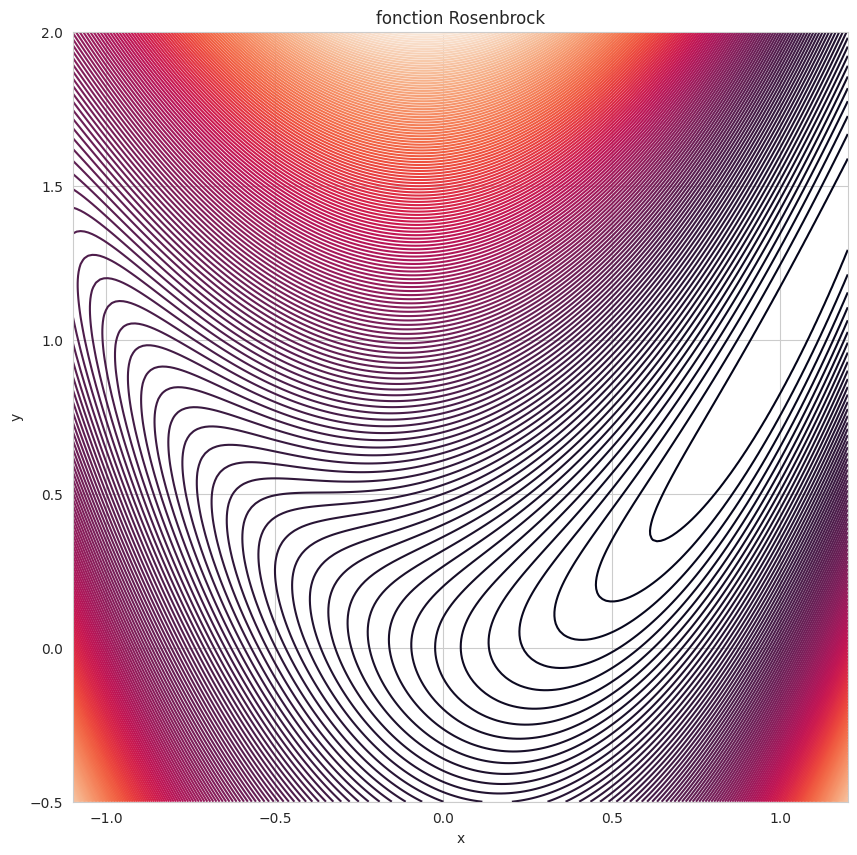

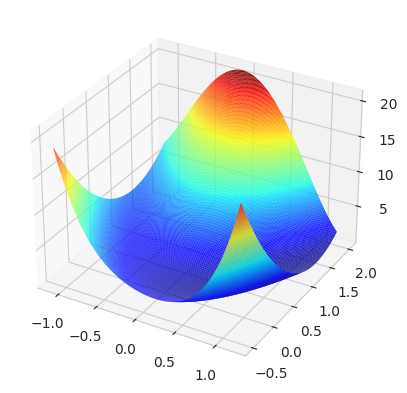

In [3]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -1.1, 1.2, -0.5, 2
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=Rosenbrock(np.array([X[i,j],Y[i,j]]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,200) 
  
ax.set_title('fonction Rosenbrock') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
cmap='jet', edgecolor='none')

#### 2. Une fonction cubique  

In [4]:
def cubic1_(x,gamma):
        return x**3 + gamma*x**2 + x + 1 #valeur de la fonction

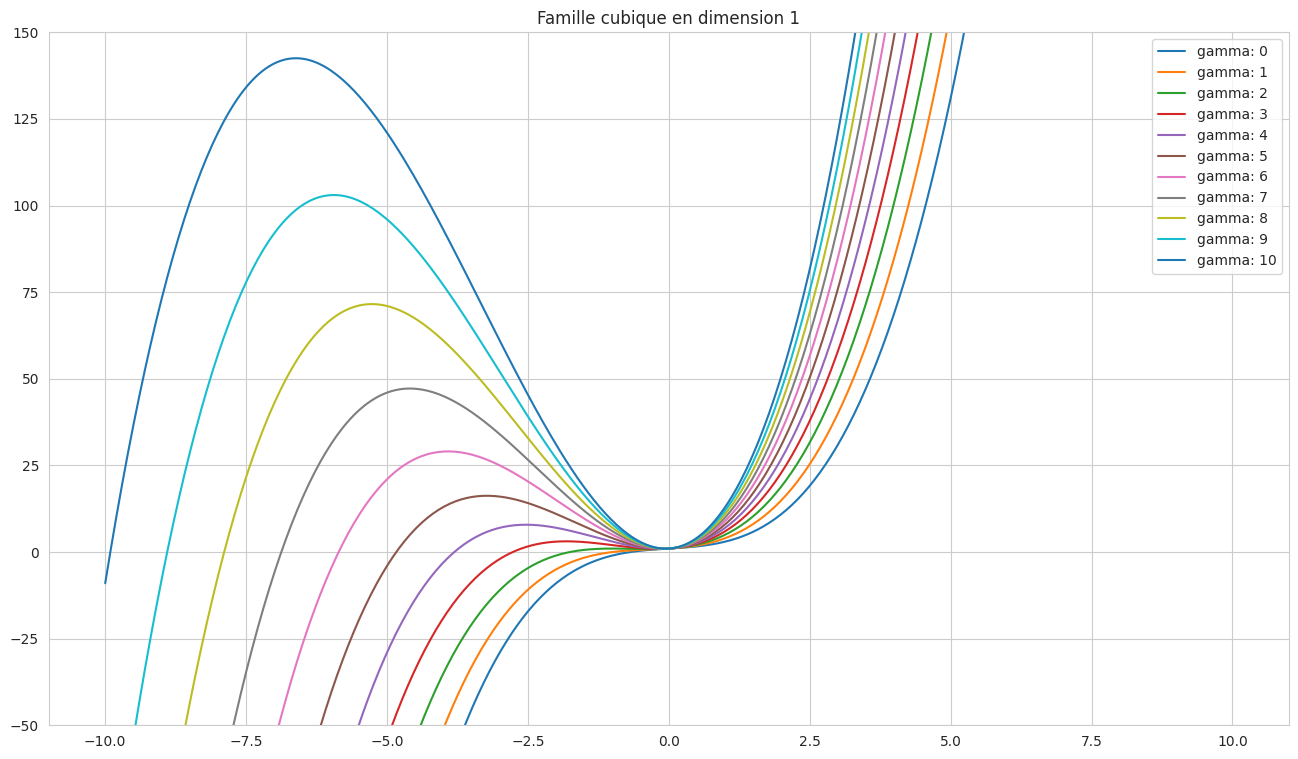

In [5]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-50, 150)
for gamma in range(0, 11, 1):
    ax.plot(x, cubic1_(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille cubique en dimension 1")
ax.legend()
plt.show()

In [6]:
def cubic2_(x,gamma=10):
        return cubic1_(x[0],gamma)+cubic1_(x[1],gamma) #valeur de la fonction ou de son grad


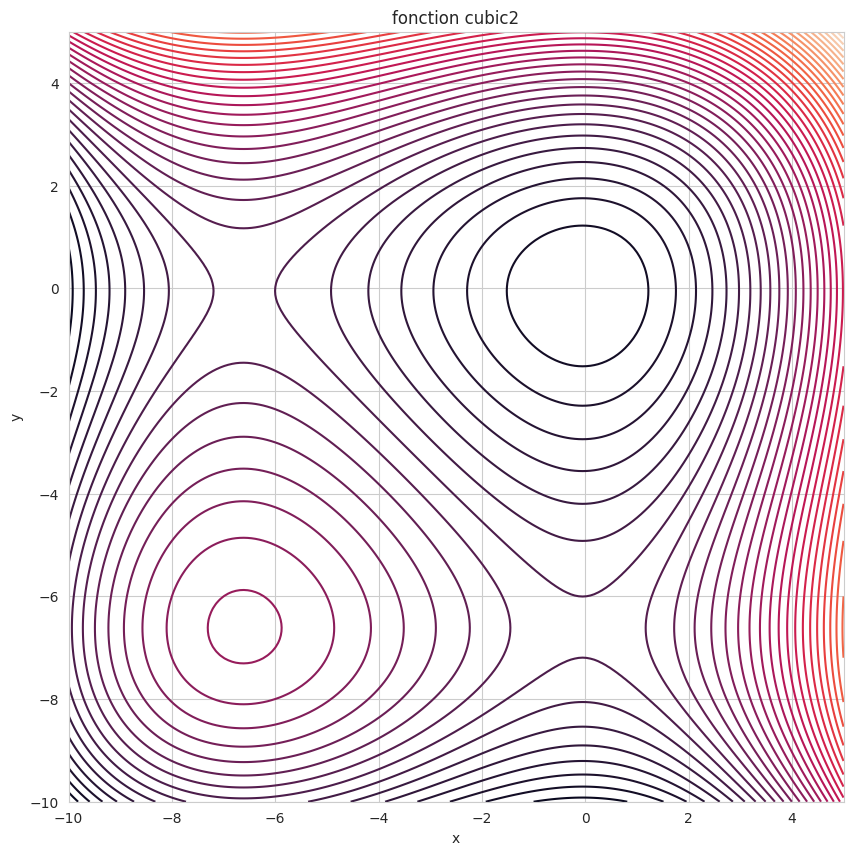

In [7]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -10, 5, -10, 5
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)


Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=cubic2_(np.array([X[i,j],Y[i,j]]))


fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,50) 
  
ax.set_title('fonction cubic2') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()




#### 3. On construit ici une fonction convexe en dimension n

On va prendre comme fonction test la fonction convexe "générique" dans $\mathbb{R}^n$, $ x \mapsto \frac{1}{2}x^T A x-b^Tx$, 

où A est une matrice symétrique définie positive de taille $(n,n)$ et $b$ un vecteur de $\mathbb{R}^n$.

On a vu en cours que cette fonction est convexe, qu'elle admet donc un minimum global sur $\mathbb{R}^n$, et que ce minimum est atteint au point où son gradient s'annule, c'est à dire au point où $Ax=b$.


Une manière commode de construire une matrice $A$ symétrique définie positive est de la voir comme une matrice de la forme $A=U^T U$ avec $U$ triangulaire supérieure car cela nous permet  à la fois de s'assurer qu'elle est symétrique, inversible, positive et en plus de "contrôler" les valeurs propres de $A$ et donc son conditionnement.
Le conditionnement de $A$ est le rapport entre la plus grande et la plus petite de ses valeurs propres.


In [8]:
def create_system (dim,cond=10,seed=100):
    np.random.seed(seed)
    U=np.random.uniform(-math.sqrt(cond),math.sqrt(cond),size=(dim,dim))/dim
    U=np.triu(U,1)
    # on remplace la diagonale de U par des valeurs aléatoires positives entre 1 et sqrt(cond)
    U=U+np.diag(np.random.uniform(1.,math.sqrt(cond),size=(dim))) 
    # on impose les deux premiers termes de la diagonale diagonale de A pour fixer le conditionnement
    U[0,0]=1.
    U[1,1]=math.sqrt(cond)
    b=1.*np.random.randint(-10,10,size=(dim))
    A=U.T @ U
    return A,b

In [9]:
A,b = create_system(10,cond=10)
print (A,b)
val,vec = np.linalg.eig(A)
print (val)

[[ 1.00000000e+00 -1.40171508e-01 -4.77392673e-02  2.18055572e-01
  -3.13243299e-01 -2.39340703e-01  1.07991203e-01  2.06087378e-01
  -2.29766927e-01  4.74931916e-02]
 [-1.40171508e-01  1.00196481e+01 -6.22651876e-01 -8.13811398e-01
  -5.16697229e-01  9.90796317e-01  6.08229008e-01 -6.85005553e-01
   6.64656274e-01 -4.58509698e-01]
 [-4.77392673e-02 -6.22651876e-01  5.42288950e+00 -2.01557927e-01
  -4.25972086e-01 -2.35386731e-01 -7.69594143e-01 -3.31762985e-01
   4.04934468e-01 -6.85002788e-01]
 [ 2.18055572e-01 -8.13811398e-01 -2.01557927e-01  2.90234566e+00
  -4.92147123e-01  2.93065733e-01  5.14512462e-01 -3.51714755e-01
   2.93016066e-01  1.58658076e-01]
 [-3.13243299e-01 -5.16697229e-01 -4.25972086e-01 -4.92147123e-01
   6.55119294e+00  3.63317775e-02  3.33226894e-01 -3.09594974e-01
  -4.13987285e-01  6.18256953e-01]
 [-2.39340703e-01  9.90796317e-01 -2.35386731e-01  2.93065733e-01
   3.63317775e-02  8.38950897e+00 -4.43154475e-01 -6.46970597e-01
  -6.65242200e-01 -1.83478229e-03

In [10]:
def quadraticn_(x):
        return (x.T@A@x)/2-b.T@x #valeur de la fonction


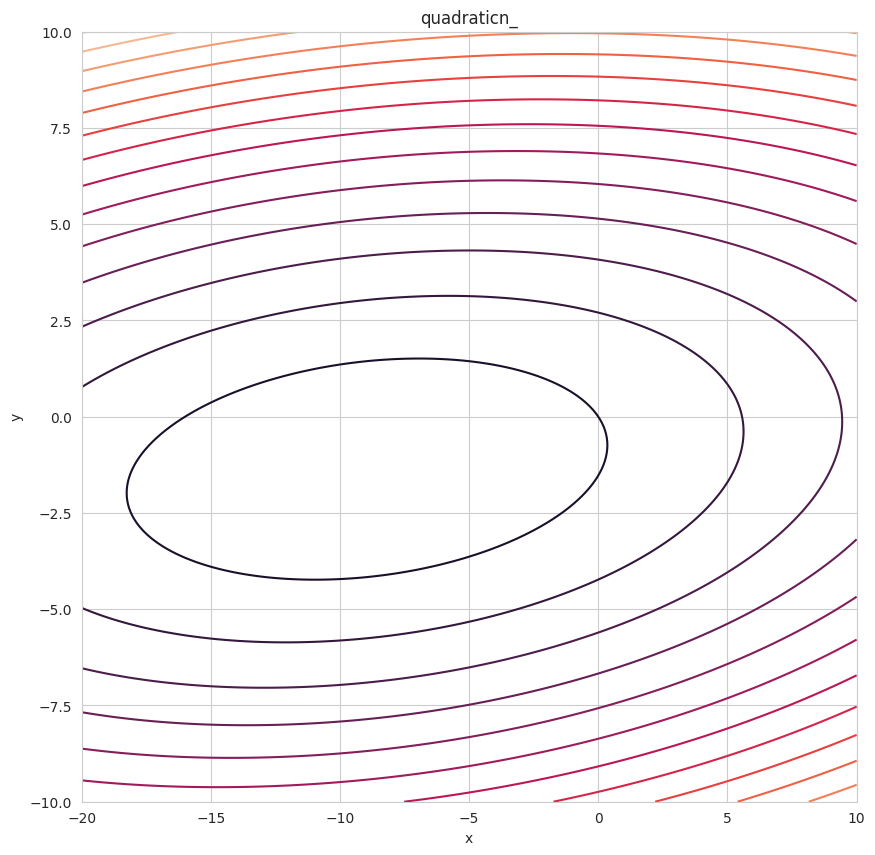

In [11]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -20, 10, -10, 10

x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

dim=2
A,b = create_system(dim,cond=10)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=quadraticn_(np.array([X[i,j],Y[i,j]]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 

ax.contour(X, Y, Z,15) 
  
ax.set_title('quadraticn_') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 

plt.show()


### Conclusion

On voit sur ces quelques exemples que des fonctions d'apparence "inoffensives" peuvent avoir des comportements complexes en ce qui concerne leurs extrema locaux ou globaux.

${\bf Nous \, vous \, invitons \, à \, tester \, vos \, programmes}$
* sur la fonction quadratique pour la dimension n=2 puis n=10, et pour des conditionnements variant de 5 à 1000.
* sur la fonction de Rosenbrock pour des valeurs de gamma variant de 5 à 100

## II- Différencier une fonction numériquement

Pour calculer le gradient d'une fonction on a déjà besoin de savoir calculer la dérivée d'une fonction réelle, et on en tire ensuite une version numérique du gradient.

### Le calcul numérique de la dérivée

Pour $h$ assez petit on peut approcher $f'(x)$ par 
$$ f'(x) \simeq \frac{f(x + h) - f(x)}{h} .$$
L'erreur de l'approximation est en $o(1)$ quand $h \to 0$. 

$$ $$
On peut en réalité faire un peu mieux en approchant $f'(x)$ par 
$$f'(x) \simeq \frac{f(x+h)-f(x-h)}{2h}$$.
On trouve que l'erreur d'approximation dans le second cas est désormais en $o(h)$ quand $h \to 0$; ce qui est a priori meilleur.

#### 1. Utiliser la démarche précédente pour approcher la dérivée partielle d'une fonction en un point. Cette fonction sera notée `partial`.

In [12]:
def partial(f, x, i=0, dx=1e-8, has_gamma = False):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    if has_gamma:
        gamma = x[-1]
        x = x[:-1]
    dim = len(x)
    h = np.array([0.] * dim)
    h[i] = dx
    if has_gamma:
        return (f(x + h, gamma) - f(x - h, gamma)) / h[i] / 2
    else:
        return (f(x + h) - f(x - h)) / h[i] / 2

#### 2. Comparer `partial` à l'expression exacte de la dérivée partielle d'une fonction de votre choix. 

In [13]:
def rosenbrock_grad(x, gamma):
    grad_x = 2*(x[0]-1) + 2*gamma*(2*x[0])*(x[0]**2-x[1])
    grad_y = -2*gamma*(x[0]**2-x[1])
    return np.array([grad_x, grad_y])

def quadraticn_grad(x, dim, cond):
    A,b = create_system(dim,cond)
    return A@x-b

def cubic1_grad(x):
    return 3*x[0]**2 + 2*x[1]*x[0] + 1

def cubic2_grad(x):
    return np.array([cubic1_grad(x[0], x[2]), cubic1_grad(x[1], x[2])])

In [14]:
x0 = [5,5]
gamma = 10
x_exact = rosenbrock_grad(x0, gamma)[0]
res = partial(Rosenbrock,x0 + [gamma], has_gamma=True)

print("x_calculé",res)
print ("x_exact",x_exact)

x_calculé 4007.999973509868
x_exact 4008


### Le calcul du gradient

Comme dit précédemment, comme le calcul exact du gradient n'est parfois pas possible ou facile, on se garde la possibilité de calculer numériquement le gradient d'une fonction.

#### 1. Écrire une fonction `gradient` qui renvoie le gradient d'une fonction en un point grâce à la fonction précédente

In [15]:
def gradient(f, x, dx=1e-5, has_gamma = False):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    dim = len(x)
    if has_gamma:
        dim -= 1
    grad = [0] * dim
    for i in range(dim):
        grad[i] = partial(f, x, i, dx, has_gamma)
    return np.array(grad)


#### 2. Tester cette fonction gradient sur une fonction connue.

In [16]:
x0 = [5,5]
gamma = 10
x_exact = rosenbrock_grad(x0, gamma)
res = gradient(Rosenbrock,x0 + [gamma], has_gamma=True)

print("x_calculé",res)
print ("x_exact",x_exact)

x_calculé [4007.99999986 -399.99999997]
x_exact [4008 -400]


# PARTIE I- Les méthodes de descente "classiques" pour une fonction différentiable

Cette partie représente la première partie du TP est devrait être bien entamée lors de la première séance de TP et achevée (y compris la partie "rapport") avant la deuxième séance de TP. 


## I- Descente du gradient

Tout d'abord, nous allons implémenter des descentes qui se feront dans la direction du Gradient


### le cas générique de descente de gradient avec un pas constant


* prendre un point de départ au hasard ${\bf p_0}$.

Quand on est au point ${\bf p_k}$

* calculer le gradient de J en ce point $\nabla J({\bf p_k})$

* On choisit une direction de descente ${\bf d}_k = - \nabla J({\bf p}_k)$

* avancer dans cette direction : ${\bf p}_{k+1} = {\bf p}_k + \mu \, {\bf d}_k$

et on recommence cette dernière étape jusqu'à ce qu'on arrive à un point fixe c.a.d. que 
$|| {\bf p}_{k+1} - {\bf p}_k|| < \varepsilon$ avec $\varepsilon$ une toute petite valeur.

Implémenter cette méthode, la tester sur des fonctions tests définies plus haute, observer en particulier le comportement en fonction de $\mu$ qui est le pas constant.

Attention: bien prévoir dans le code des conditions pour éviter de se retrouver piégé dans des boucles infinies !!!

#### 1. Implémenter cette méthode, la tester sur des fonctions tests définies plus haute, observer en particulier le comportement en fonction de $\mu$ qui est le pas constant.

Attention: bien prévoir dans le code des conditions pour éviter de se retrouvé piégé dans des boucles infinies !!!
On conseille de stocker les différentes valeurs calculées pour les points ${\bf p_k}$ afin de pouvoir "regarder" la manière dont la convergence se passe.

In [17]:
def desc_grad_const (f,p0,mu=0.001,eps=1E-6):
    """
    Description: 
    Parameters:
    p0: point initial
    f: fonction à minimiser
    mu: valeur 
    
    Output
    liste comportant l'ensemble des pk
    """
    pk = p0
    grad = gradient(f, pk)
    pk_list = [pk]
    while np.linalg.norm(grad) > eps:
        pk = pk - mu * grad
        pk_list.append(pk)
        grad = gradient(f, pk)
    return pk_list

#### 2. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [18]:
dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_grad_const(quadraticn_,x0,mu=0.01)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 1472
x_calculé [0.99999893 1.         1.         1.00000005 0.99999998 0.99999999
 1.00000001 1.00000001 0.99999999 1.00000004]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 1ère amélioration: le choix d'un pas "optimal" à chaque étape par *backtracking* (ou rebroussement avec critère d'Armijo)

Vous devriez avoir constatés que le choix du pas de descente dans le cas constant est crucial pour garantir la convergence de l'algorithme de descente. Dans cette section on s'intéresse à un calcul adaptatif du pas de descente qui permet de mieux garantir la convergence de notre algo. Le désavantage est le temps que prend désormais chaque itération pour s'exécuter.


Ici on veut imposer la décroissance de la suite $J({\bf p}_k)$ ce qui nous assurera la convergence. Mais pour assurer la convergence vers un minimum, il faut imposer un peu plus que simplement de descendre, c'est ce que traduit le critère d'Armijo.

On prend ici deux paramètres $0<\alpha<0.5$ et $0<\beta<1$.

On cherche un $\mu$ qui vérifie:
$$ J({\bf p}_k+\mu d_k) < J({\bf p}_k) + \alpha \, \mu \, d_k ^T \, \nabla J({\bf p}_k)\quad (1).$$

On a vu en cours q'un tel $\mu$ existe dès que $d_k$ est une direction de descente (c'est à dire dès que $d_k ^T \, \nabla J({\bf p}_k) \, <\, 0$.

* On part de $\mu = 1$

* si la condition $(1)$ ci-dessus est vérifiée on choisit cette valeur de $\mu$

* sinon on change $\mu$ en $\beta \, \mu$

Et on recommence jusqu'à ce que la condition $(1)$ soit vérifiée.




#### 1. Écrire une fonction `backtracking` qui permet de calculer le pas par *backtracking* avec critère d'Armijo à une itération donnée. Pour rappel le *backtracking* a deux hyper-paramètre $\alpha$ et $\beta$ que vous mettrez par défaut à $0.4$ et $0.8$.

In [19]:
# Cette fonction génère la taille du pas optimal vérifiant le critère d'Amijo

def backtrack(x0, f , dir_x, alpha = 0.4, beta = 0.8):
    """
    Description: 
    Parameters:
    x0: point actuel
    f: fonction à minimiser
    dir_x: direction dans laquelle on souhaite aller
    
    Output
    valeur du pas choisi
    """
    mu = 1
    while f(x0 + mu * dir_x) > f(x0) + alpha * mu * np.dot(gradient(f, x0), dir_x):
        mu = beta * mu
    return mu


La méthode est donc très analogue à la précédente

* prendre un point de départ au hasard ${\bf p_0}$.

Quand on est au point ${\bf p_k}$

* Calculer le gradient de J en ce point $\nabla J({\bf p_k})$

* Choisir une direction de descente ${\bf d}_k = - \nabla J({\bf p}_k)$

* Trouver $\mu_k$ par "backtracking" dans la direction ${\bf d}_k$

* Avancer dans cette direction et avec ce pas : ${\bf p}_{k+1} = {\bf p}_k + \mu \, {\bf d}_k$

et on recommence ces étapes jusqu'à ce qu'on arrive à un point fixe c.a.d. que 
$|| {\bf p}_{k+1} - {\bf p}_k|| < \varepsilon$ avec $\varepsilon$ une toute petite valeur.

#### 2. Implémenter cette méthode

In [20]:
def desc_grad_opti (f,p0,eps=1E-6):
    """
    Description: 
    Parameters:
    p0: point initial
    f: fonction à minimiser
    
    Output
    liste comportant l'ensemble des pk
    """
    pk = p0
    grad = gradient(f, pk)
    pk_list = [pk]
    while np.linalg.norm(grad) > eps:
        mu = backtrack(pk, f, -grad)
        pk = pk - mu * grad
        pk_list.append(pk)
        grad = gradient(f, pk)
    return pk_list

#### 3. Tester cette descente sur des cas simples (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [21]:
dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_grad_opti(quadraticn_,x0,eps=1E-4)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 573
x_calculé [0.99992056 0.99999979 1.0000003  1.00000337 0.99999848 0.99999906
 1.00000051 1.00000078 0.99999894 1.00000289]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [22]:
x0 = [-1,-1]
gamma = 5
x_exact = [1, 1]
res = desc_grad_opti(Rosenbrock,x0)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 795
x_calculé [0.99999917 0.9999983 ]
x_exact [1, 1]


#### 4. Comparer la descente par backtracking et la descente à pas constant (à vous de réfléchir à ce que vous voulez comparer).

In [23]:
x0 = [-1,-1]
gamma = 5
x_exact = [1, 1]

nb_iterations = 10

start = time.time()
for i in range(nb_iterations):
    res_opti = desc_grad_opti(Rosenbrock,x0)
end = time.time()
opti_time = (end - start) / nb_iterations

start = time.time()
for i in range(nb_iterations):
    res_const = desc_grad_const(Rosenbrock,x0)
end = time.time()
const_time = (end - start) / nb_iterations

print(f"Constant step descent execution time: {const_time}s")
print(f"Backtracking descent execution time: {opti_time}s")

Constant step descent execution time: 0.8859491586685181s
Backtracking descent execution time: 0.34581818580627444s


## II- Changement de direction de descente

Maintenant nous ne nous déplacerons plus nécessairement dans la direction de $-\nabla J({\bf p_k})$ mais dans une autre direction $d_k$ qui vérifiera bien évidemment $\langle \nabla J({\bf p_k}) , d_k \rangle < 0$ afin que ce soit bien une direction de descente (et non de montée !!!).

### 1. Choisir une direction de descente selon la plus forte pente en norme $l_1$

Nous allons ici choisir la descente de plus forte pente dans le cas de la norme $\ell_1$ : la direction de descente $d_k$ suit le vecteur de la base canonique de plus grande dérivée partielle en valeur absolue. 

$$ {\bf d}_k = -\langle \nabla J({\bf p}_k),e_i \rangle \, e_i$$
où $i$ est le plus petit indice tel que:
$ \left| \dfrac{\partial J}{\partial x_i}({\bf p}_k) \right| = \|\nabla J({\bf p}_k)\|_{\infty}  $

#### a. Écrire une fonction `dsgd` qui calcule cette direction de descente de plus forte pente dans le cas de la norme $\ell_1$. 

In [24]:
def dsgd(f, x):
    
    """
    Description: 
    Parameters:
    x: point actuel
    f: fonction à minimiser
    
    Output
    vecteur de direction de descente de gradient maximal en norme l1
    """
    
    grad = gradient(f, x)
    
    i = np.argmax(np.abs(grad))
    d = np.zeros(len(x))
    d[i] = -grad[i]
    
    return d



#### b. Ecrire la descente à pas optimal avec cette direction de descente

${\bf p}_{k+1} = {\bf p}_k + \mu_k {\bf d}_k$, où $\mu_k$ est calculé de manière optimale par l'algorithme de rebroussement avec critère d'Amijo défini plus haut.

In [25]:
def desc_l1 (f, p0, eps=1E-6):
    p = p0
    p_list = [p]
    while True:
        d = dsgd(f, p)
        mu = backtrack(p, f, d)
        new_p = p + mu * d
        if np.linalg.norm(new_p - p, ord=1) < eps:
            break
        p_list.append(new_p)
        p = new_p
    return p_list

#### c. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [26]:
dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_l1(quadraticn_,x0,eps=1E-4)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 49
x_calculé [0.99288996 0.99995829 1.00003148 1.00038463 0.99982703 1.00002155
 1.00009109 1.00006308 0.99995112 1.00051601]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [27]:
x0 = [-1,-1]
gamma = 5
x_exact = [1, 1]
res = desc_l1(Rosenbrock,x0)

print ("Nb itérations",len(res))
print("x_calculé",res)
print ("x_exact",x_exact)

Nb itérations

 315
x_calculé [[-1, -1], array([-0.00920808, -1.        ]), array([-0.00920808,  0.07383287]), array([0.51634728, 0.07383287]), array([0.51634728, 0.28083058]), array([0.59290861, 0.28083058]), array([0.59290861, 0.35675491]), array([0.65310788, 0.35675491]), array([0.65310788, 0.43169672]), array([0.694945  , 0.43169672]), array([0.694945  , 0.48672795]), array([0.72408819, 0.48672795]), array([0.72408819, 0.52707462]), array([0.75012248, 0.52707462]), array([0.75012248, 0.56530962]), array([0.77383454, 0.56530962]), array([0.77383454, 0.601291  ]), array([0.79541028, 0.601291  ]), array([0.79541028, 0.634992  ]), array([0.81110247, 0.634992  ]), array([0.81110247, 0.65957555]), array([0.82535859, 0.65957555]), array([0.82535859, 0.68281267]), array([0.83857476, 0.68281267]), array([0.83857476, 0.70471158]), array([0.85082153, 0.70471158]), array([0.85082153, 0.72531206]), array([0.86216608, 0.72531206]), array([0.86216608, 0.74465905]), array([0.8726714 , 0.74465905]), array([0.8726

#### d. Comparer la descente $\ell_1$ et la descente du gradient

In [28]:
x0 = [-1,-1]
gamma = 5
x_exact = [1, 1]

nb_iterations = 10

start = time.time()
for i in range(nb_iterations):
    res_l1 = desc_l1(Rosenbrock,x0)
end = time.time()
l1_time = (end - start) / nb_iterations

start = time.time()
for i in range(nb_iterations):
    res_grad = desc_grad_opti(Rosenbrock,x0)
end = time.time()
grad_time = (end - start) / nb_iterations

print(f"L1 descent execution time: {l1_time}s")
print(f"Gradient descent execution time: {grad_time}s")
print()
print(f"L1 descent step count: {len(res_l1)}")
print(f"Gradient descent step count: {len(res_grad)}")

L1 descent execution time: 0.1278332233428955s
Gradient descent execution time: 0.34360780715942385s

L1 descent step count: 315
Gradient descent step count: 795


### 2. le gradient conjugué (Fletcher-Reeves)

Dans la méthode du gradient conjugué, on modifie la direction de descente en ajoutant à l'opposé du gradient un terme dépendant des directions de descente précédentes. Ce choix de descente est fait pour rendre deux directions de descentes orthogonales pour le produit scalaire qui vient de la Hessienne.

Ce calcul (qui est direct quand la fonctionnelle est quadratique) peut devenir compliqué quand la Hessienne n'est pas directement accessible.

Une des méthodes les plus populaires pour une fonctionnelle quelconque est celle proposée par Fletcher-Reeves. Nous vous invitons à faire un peu de bibliographie (ou vos notes de cours) pour trouver comment la direction est choisie.

Réponse: $d_{k+1}=$

#### a. Ecrire la descente à pas optimal avec cette direction de descente

In [29]:
def desc_FR (f, p0, eps=1E-6):
    p = p0
    d = -gradient(f, p)
    p_list = [p]
    while True:
        mu = backtrack(p, f, d)
        new_p = p + mu * d
        if np.linalg.norm(new_p - p, ord=2) < eps:
            break
        new_grad = gradient(f, new_p)
        beta = np.linalg.norm(new_grad, ord=2) ** 2 / np.linalg.norm(gradient(f, p), ord=2) ** 2
        d = -new_grad + beta * d
        p_list.append(new_p)
        p = new_p
    
    return p_list

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [30]:
dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_FR(quadraticn_,x0,eps=1E-4)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 32
x_calculé [0.99936891 0.99998458 0.99994619 0.99999994 0.99998564 0.99998647
 0.99997442 1.0000008  1.00000319 0.99997965]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 3. le gradient conjugué (Polack-Ribière)

Une méthode alternative est celle proposée par Polack-Ribière. Nous vous invitons à faire un peu de bibliographie (ou vos notes de cours) pour trouver comment la direction est choisie.

Réponse: Réponse: $d_{k+1}=$

#### a. Ecrire la descente à pas optimal avec cette direction de descente

In [31]:
def desc_PR (f, p0, eps=1E-6):
    p = p0
    d = -gradient(f, p)
    p_list = [p]
    while True:
        mu = backtrack(p, f, d)
        new_p = p + mu * d
        if np.linalg.norm(new_p - p, ord=2) < eps:
            break
        new_grad = gradient(f, new_p)
        beta = np.dot(new_grad, new_grad - gradient(f, p)) / np.linalg.norm(gradient(f, p), ord=2) ** 2
        d = -new_grad + beta * d
        p_list.append(new_p)
        p = new_p
    
    return p_list

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [32]:
dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_PR(quadraticn_,x0,eps=1E-4)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 44
x_calculé [1.00017314 0.99998789 0.99997263 0.99993916 0.99998403 1.00000682
 1.00002516 0.99999352 1.00001297 1.00010984]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## III - "Les" méthodes de Newton

### 1. la méthode de Newton

Dans les méthodes de descente précédentes, on cherchait à chaque étape à minimiser le Développement Limité d'ordre 1 de J au voisinage de ${\bf p_k}$: $h \mapsto J({\bf p_k}) + \nabla J({\bf p_k}) ^T h$.

Dans la méthode de Newton, on cherche à minimiser le Développement Limité d'ordre 2 de J au voisinage de ${\bf p}_k$ : $h \mapsto J({\bf p}_k) + \nabla J({\bf p}_k) ^T h + \dfrac{1}{2}h^T H_J({\bf p}_k) h$ où $H_J({\bf p}_k)$ est la Hessienne de J au point ${\bf p}_k$.

A quelle direction de descente, cette minimisation nous amène-t-elle?

Réponse:


On passe de la direction ${\bf d}_k$ à la direction ${\bf d}_{k+1}$ par la relation de récurrence:
$${\bf d}_{k+1}=-H_J({\bf p}_k)^{-1} \, \nabla J({\bf p}_k) .$$

#### a. Implémenter la méthode de Newton.

En apparence, implémenter la méthode de Newton (qui converge très rapidement) ne semble pas différent que les méthodes de descente vues précédemment (Une fois qu'on a obtenu ${\bf d}_k$ comme direction de descente, on peut calculer $\mu_k$ et donc itérer "tranquillement).

En réalité cette méthode n'est pas facile à implémenter et surtout coûteuse car il faut calculer à chaque itération la Hessienne de $J$ au point ${\bf p}_k)$ et ensuite l'inverser.

Vous pouvez essayer de l'implémenter dans le cas particulier de la fonction quadraticn_ car alors la matrice Hessienne est constante et ne dépend donc pas du point ${\bf p}_k)$, ce qui vous permet de calculer une fois pour toute son inverse (par le module linalg de numpy par exemple).

Par contre implémenter cette méthode dans le cas d'une fonction dont on ne connaît pas explicitement la Hessienne, et surtout l'inverse de cette dernière est à déconseiller.

In [33]:
### Facultatif

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

### 2. la méthode de quasi-Newton

Pour éviter les inconvénients de la méthode de Newton, en particulier lorsque la Hessienne n'est plus constante, une idée est d'introduire une suite de matrices $H_k$ qui sont une approximation de $\bf {l'inverse}$ de la Hessienne au point ${\bf p}_k$.

Cette méthode qui s'appelle méthode BFGS (des initiales des auteurs) qui l'ont introduite, a l'avantage (énorme) de ne pas nécessiter le calcul de la Hessienne ou de son inverse. on retrouve donc en terme d'implémentation la simplicité des méthodes de descente, tout en ayant les propriétés de convergence de la méthode de Newton.

Nous vous invitons à faire un peu de bibliographie ou de revoir vos notes de cours pour trouver la manère de construire cette suite $H_k$

La méthode est donc très analogue à la précédente

* prendre un point de départ quelconque ${\bf p}_0$, par exemple ${\bf p}_0 = ${\bf 0}$
* prendre une matrice $H_0$ quelconque, par exemple $H_0= I_n$ 

Quand on est au point ${\bf p}_k$

* Choisir une direction de descente ${\bf d}_k = -H_k \, \nabla J({\bf p}_k)$

* Trouver $\mu_k$ par "backtracking" dans la direction ${\bf d}_k$

* Avancer dans cette direction et avec ce pas : ${\bf p}_{k+1} = {\bf p}_k + \mu \, {\bf d}_k$

* Calculer $H_{k+1}$ en fonction de $H_k$, $J({\bf p}_k)$, $J({\bf p}_{k+1})$, $\nabla J({\bf p}_k)$ et $\nabla J({\bf p}_{k+1})$.

et on recommence ces étapes jusqu'à ce qu'on arrive à un point fixe c.a.d. que 
$|| {\bf p}_{k+1} - {\bf p}_k|| < \varepsilon$ avec $\varepsilon$ une toute petite valeur.


Faire un petit peu de biblio pour trouver comment se calcule la suite des matrices $H_{k+1}$. La formule qui semble à première vue horrible, se programme en Python en 1 ligne en ne faisant que des multiplications de matrices et de vecteurs.

In [34]:
def bfgs_update(H_k, y_k, s_k):
    n = len(s_k)
    I_n = np.eye(n)
    yTs = np.dot(y_k.T, s_k)
    syT = np.outer(s_k, y_k.T)
    ysT = np.outer(y_k, s_k.T)
    ssT = np.outer(s_k, s_k.T)

    H_k1 = (I_n - syT / yTs) @ H_k @ (I_n - ysT / yTs) + ssT / yTs
    return H_k1

Réponse:
Si on note ${\bf s}_k = {\bf p}_{k+1} - {\bf p}_k$ et ${\bf y}_k = \nabla J({\bf p}_{k+1}) - \nabla J({\bf p}_k)$.

On a alors:
$$ H_{k+1}=$$

#### a. Implémenter la méthode de Quasi-Newton BFGS.

In [35]:
def desc_BFGS (f, p0, eps=1E-6):
    p = p0
    n = len(p)
    H = np.eye(n)
    grad = gradient(f, p)
    p_list = [p]
    while np.linalg.norm(grad) > eps:
        d = -H @ grad
        mu = backtrack(p, f, d)
        p_new = p + mu * d
        grad_new = gradient(f, p_new)
        
        s = p_new - p
        y = grad_new - grad
        rho = 1.0 / (y.T @ s)
        
        H = (np.eye(n) - rho * np.outer(s, y)) @ H @ (np.eye(n) - rho * np.outer(y, s)) + rho * np.outer(s, s)
        p_list.append(p_new)
        p, grad = p_new, grad_new
    
    return p_list

#### b. Tester cette descente sur un cas simple (prendre par exemple en dimension n=10, la fonction quadraticn_ dans un cas où vous connaissez la solution).

In [36]:
dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_BFGS(quadraticn_,x0,eps=1E-4)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 14
x_calculé [0.99998622 0.99999981 0.99999987 1.00000049 0.99999955 0.99999963
 0.9999999  0.99999992 0.99999968 1.00000031]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [37]:
x0 = [-1,-1]
gamma = 5
x_exact = [1, 1]
res = desc_BFGS(Rosenbrock,x0)

print ("Nb itérations",len(res))
print("x_calculé",res)
print ("x_exact",x_exact)

Nb itérations 16
x_calculé [[-1, -1], array([-0.00920808, -0.54964004]), array([-0.15860052, -0.08435329]), array([-0.09541162, -0.05121276]), array([ 0.34294749, -0.033964  ]), array([0.4756966 , 0.10106139]), array([0.62130025, 0.44025824]), array([0.87750402, 0.67369854]), array([0.8254607 , 0.67087369]), array([0.88860308, 0.77916067]), array([0.98644436, 0.95688624]), array([0.99137879, 0.98216938]), array([0.99946543, 0.99881548]), array([0.99999303, 0.99998222]), array([0.99999994, 0.99999992]), array([1., 1.])]
x_exact [1, 1]


3. Comparer la méthode de quasi-Newton aux descentes précédentes.

In [38]:
x0 = [-1,-1]
gamma = 5
x_exact = [1, 1]

nb_iterations = 10

start = time.time()
for i in range(nb_iterations):
    res_ista = desc_PR(Rosenbrock,x0)
end = time.time()
pr_time = (end - start) / nb_iterations

start = time.time()
for i in range(nb_iterations):
    res_fista = desc_BFGS(Rosenbrock,x0)
end = time.time()
bfgs_time = (end - start) / nb_iterations

print(f"PR descent execution time: {pr_time}s")
print(f"Netwon descent execution time: {bfgs_time}s")
print()
print(f"PR descent step count: {len(res_ista)}")
print(f"Netwon descent step count: {len(res_fista)}")

PR descent execution time: 0.015927338600158693s
Netwon descent execution time: 0.002831244468688965s

PR descent step count: 23
Netwon descent step count: 16


## IV. visualiser et comparer les différents algorithmes de descente et leur sensibilité par rapport au conditionnement

Nous vous proposons de visualiser le comportement de ces différents algorithmes de descente.


### 1. visualiser de la manière dont les points se rapprochent du minimum

Tout d'abord en dimension 2, vous pouvez tracer la succession des points $p_k$ pour les algorithmes implémentés en les superposant les courbes de niveau de la fonctionnelle.
Vous pourrez le faire pour la fonction quadratique et pour la banane de Rosenbrock.

<function matplotlib.pyplot.show(close=None, block=None)>

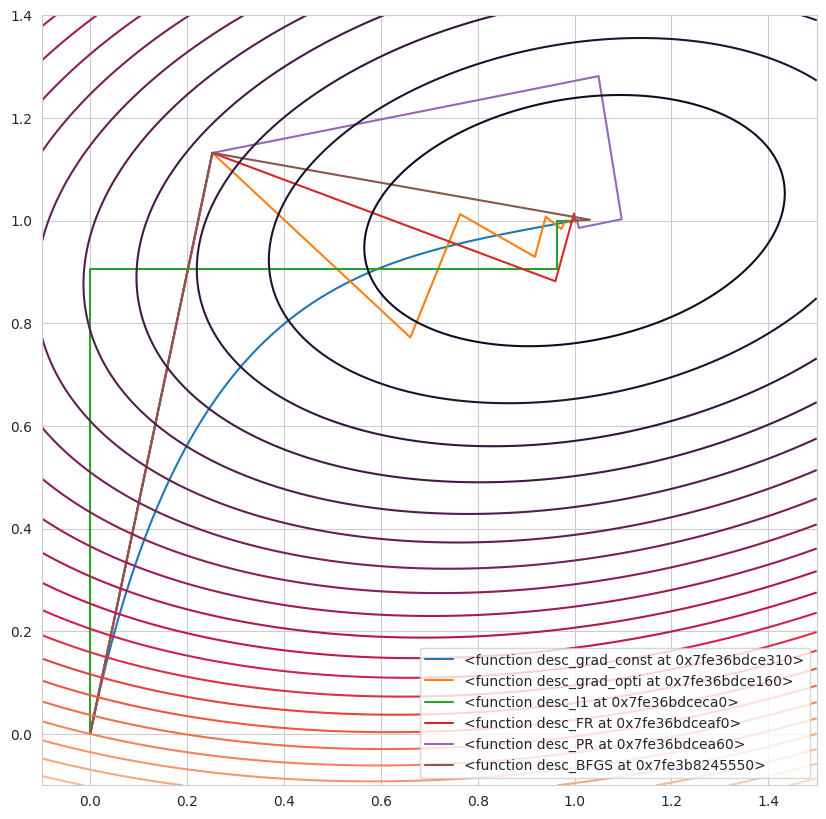

In [41]:
dim=2
A,b = create_system(dim,cond=3.)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)

plt.figure(figsize=(10,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1,desc_FR,desc_PR,desc_BFGS)

for method in Liste_method:

    if method == desc_grad_const:
        res = method(quadraticn_,x0,mu=0.9/cond)
    else:
        res = method(quadraticn_,x0)
    res = np.stack(res, axis=0)
    plt.plot(res[:,0], res[:,1],label=method)

plt.legend()

nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -0.1, 1.5, -0.1, 1.4

x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=quadraticn_(np.array([X[i,j],Y[i,j]]))
        
        
plt.contour(X, Y, Z,25) 

plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

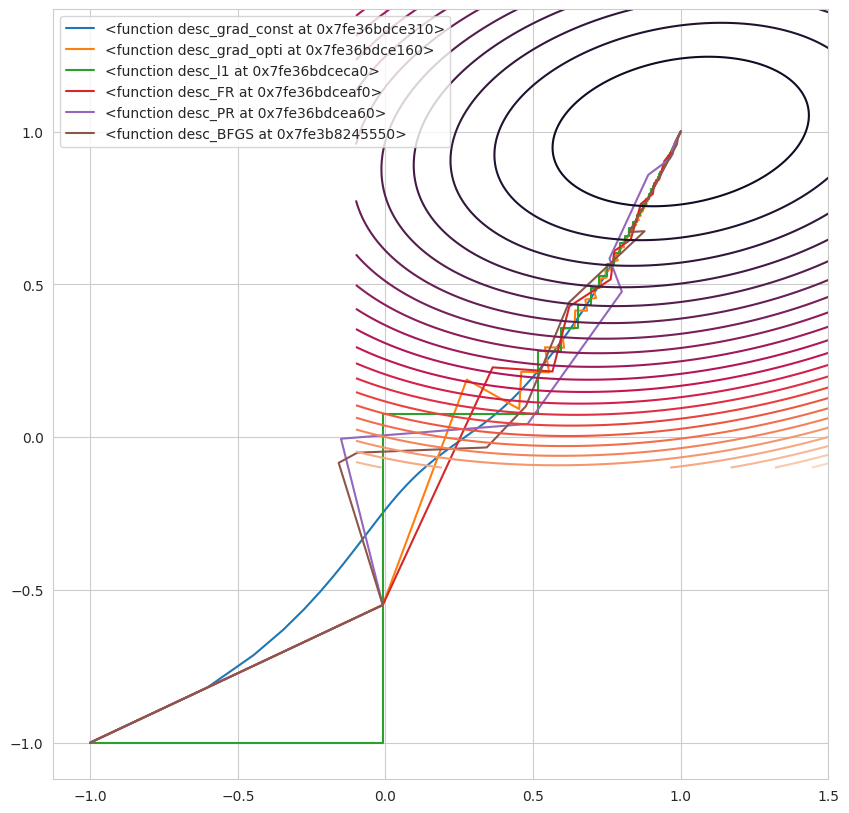

In [42]:
x0 = [-1,-1]
x_exact = [1, 1]

plt.figure(figsize=(10,10))

Liste_method=(desc_grad_const,desc_grad_opti,desc_l1,desc_FR,desc_PR,desc_BFGS)

for method in Liste_method:

    if method == desc_grad_const:
        res = method(Rosenbrock,x0,mu=0.9/cond)
    else:
        res = method(Rosenbrock,x0)
    res = np.stack(res, axis=0)
    plt.plot(res[:,0], res[:,1],label=method)

plt.legend()

nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -0.1, 1.5, -0.1, 1.4

x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(y_mi, y_ma, nb_pts)
X, Y = np.meshgrid(x, y)

Z=np.zeros((nb_pts,nb_pts))

for i in range (nb_pts):
    for j in range (nb_pts):
        Z[i,j]=quadraticn_(np.array([X[i,j],Y[i,j]]))
        
        
plt.contour(X, Y, Z,25) 

plt.show


### 2. Visualiser la vitesse de convergence des différents algorithmes de descente et leur sensibilité par rapport au conditionnement

En dimension n plus grande (par exemple n=10), vous pourrez tracer le nombre d'itérations nécessaires pour converger en fonction du conditionnement (5,10,50,100,500,1000).

6
9


KeyboardInterrupt: 

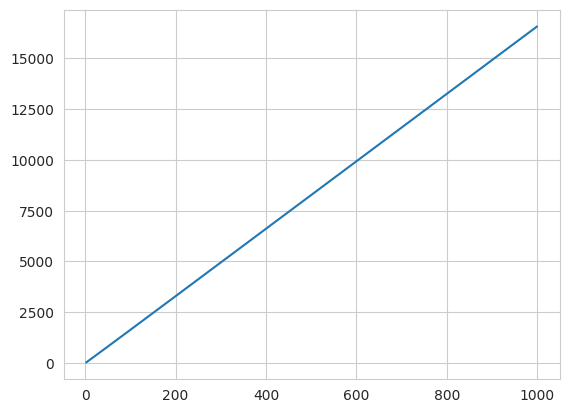

In [44]:
dim=10

Liste_cond=(2,5,10,20,50,100,200, 500,1000)
Liste_method=(desc_grad_const,desc_grad_opti,desc_l1,desc_FR,desc_PR,desc_BFGS)
iter=np.zeros(len(Liste_cond))

for method in Liste_method:
    print(k)
    k=0
    for cond in Liste_cond:
        A,b = create_system(dim,cond)
        x_exact=np.zeros(dim)+1.
        b=A@x_exact
        x0=np.zeros(dim)
    
        if method == desc_grad_const:
            res = method(quadraticn_,x0,mu=0.9/cond)
        else:
            res = method(quadraticn_,x0)
    
        iter[k]=len(res)
    
        k=k+1
    
    plt.plot(Liste_cond[:], iter[:],label=method)

plt.yscale('log')

plt.legend()

plt.show

    

    

Vous pouvez aussi regarder pour une certaine valeur de conditionnement, comment varie la distance à la solution exacte en fonction de l'itération.

In [ ]:
dim=10
cond=1000
Liste_method=(desc_grad_const,desc_grad_opti,desc_l1,desc_FR,desc_PR,desc_BFGS)

A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact
x0=np.zeros(dim)

l=0
for method in Liste_method:
    if method == desc_grad_const:
        res = method(quadraticn_,x0,mu=0.9/cond)
    else:
        res = method(quadraticn_,x0)
    
    xx=np.zeros(len(res))
    yy=np.zeros(len(res))
    
    for i in range(len(res)):
        xx[i]=i
        yy[i]=np.sqrt((res[i]-x_exact)@(res[i]-x_exact))
    
    plt.plot(xx,yy**0.5,label=method)
    plt.xlabel("iteration")
    plt.ylabel("erreur")
    plt.yscale('log')
    plt.xscale('log')

    plt.legend()
    
    l=l+1
    plt.show


## VI. Deux exemples d'algorithmes d'accélération

Nous vous proposons de faire un peu de recherche sur internet pour 2 méthodes d'accélération. La méthode appelée "Momentum acceleration" et celle appelée "Nesterov Acceleration". Ensuite vous programmez ces deux méthodes, vous regardez sur les exemples précédents leur comportement, vous visuaalisez la manière dont ils convergent, et vous commentez sur une amélioration ou non de ces méthodes par rapport à celles vues au début du TP. Pour quellles situations ces méthodes ont été introduites?


### 1. Momentum Acceleration


In [52]:
def desc_mom_acc (f, p0, mu, gamma=0.9, eps=1E-6, max_iterations=1000):
    p = p0
    v = 0
    p_values = [p0]
    
    for i in range(max_iterations):
        grad = gradient(f,p)
        v = gamma*v + mu*grad
        p_new = p - v
        if np.linalg.norm(p_new - p) < eps:
            break
        p_values.append(p_new)
        p = p_new
        
    return p_values


### 2. Nesterov


In [53]:
def desc_nester (f, p0, mu, gamma=0.9, eps=1E-6, max_iterations=1000):
    p = p0
    v = 0
    p_values = [p0]
    for i in range(max_iterations):
        lookahead = p - gamma*v
        grad = gradient(f,lookahead)
        v = gamma*v + mu*grad
        p_new = p - v
        if np.linalg.norm(p_new - p) < eps:
            break
        p_values.append(p_new)
        p = p_new
    return p_values


### 3. tests et comparaisons


In [54]:
dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_mom_acc(quadraticn_,x0, 0.9/cond)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)


dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
res = desc_nester(quadraticn_,x0, 0.9/cond)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 264
x_calculé [0.99999939 0.99999965 1.0000014  0.99999911 0.99999938 0.99999991
 1.00000063 0.99999887 0.99999926 0.99999998]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Nb itérations 167
x_calculé [0.99993419 1.00000005 0.99999996 1.00000305 0.99999891 0.99999928
 1.00000026 1.00000038 0.9999994  1.00000075]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [55]:
x0 = np.array([-1,-1])
gamma = 5
x_exact = [1, 1]

nb_iterations = 10

start = time.time()
for i in range(nb_iterations):
    res_ista = desc_mom_acc(Rosenbrock,x0, 0.9)
end = time.time()
pr_time = (end - start) / nb_iterations

start = time.time()
for i in range(nb_iterations):
    res_fista = desc_nester(Rosenbrock,x0, 0.9)
end = time.time()
bfgs_time = (end - start) / nb_iterations

print(f"mom descent execution time: {pr_time}s")
print(f"Nester descent execution time: {bfgs_time}s")
print()
print(f"mom descent step count: {len(res_ista)}")
print(f"Nester descent step count: {len(res_fista)}")

mom descent execution time: 0.012401914596557618s
Nester descent execution time: 0.011052203178405762s

mom descent step count: 335
Nester descent step count: 335


# PARTIE II- Les méthodes proximales pour une fonction non différentiable


## I- Quelques éléments sur les méthodes proximales


Ici nous allons considérer un problème du type: chercher le minimum d'une fonctionnelle $J$ non nécessairement différentiable.

Nous supposerons que $J$ est définie sur $\mathbb{R}^n$ s'écrit sous la forme: $J(x)=F(x)+G(X)$ avec F différentiable, fortement convexe (c'est à dire elliptique) et $G$ convexe mais **non différentiable**.

Ce problème ne peut pas être résolu par une méthode de descente de gradient car $J$ n'est pas différentiaable.

Nous introduisons l' **opérateur proximal** ${\cal P}_G$ défini par:
$$ \begin{array}{r c l} \mathbb{R}^n & \to & \mathbb{R}^n \\
                        u&\mapsto&\displaystyle {\cal P}_G(u)=\arg \min_{v \in \mathbb{R}^n}  \left(G(v)+\frac{1}{2} ||u-v||_2^2 \right)
                        \end{array}$$


L'**algorithme du gradient proximal** consiste alors à

#### a) $k=0$, choisir un point initial $x^{(0)}$ et $u^{(0)}=x^{0}$.

#### b) Faire une descente dans la direction $-\nabla F (u^{(k)})$ en choisissant $\mu^{(k)}$ "au mieux (voir ci-dessus). $x^{(k+1)}=u^{(k)}-\mu^{(k)}\nabla F (u^{(k)})$.

#### c) Mettre à jour ensuite la variable $u$ grâce à l'opérateur proximal $u^{(k+1)}={\cal P}_{\mu^{(k)}G}(x^{(k+1)})$.

#### d) $k=k+1$ et revenir à l'étape b jusqu'à obtenir une convergence.


Comme expliqué en cours, cet algorithme n'est praticable que si l'étape c) est réalisable avec une complexité réduite.


## II- Le cas du LASSO


### 1- Le cas de la méthode LASSO


Ici on aura $F$ quadratique et $G=\lambda l_1$.

La fonction à minimiser est donc $\displaystyle J(u)= \frac{1}{2}||Au-b||^2_2 + \lambda ||u||_1$

On a vu que dans ce cas où $H=\varepsilon l_1$ (où $l_1$ est la norme 1) car alors, l'opérateur ${\cal P}_H$ s'exprime composante par composante et on a alors:

$${\cal P}_H(u)_i = \left \{ \begin{array}{lcc}
u_i + \varepsilon & si & u_i < -\varepsilon \\
0 & si & -\varepsilon < u_i < \varepsilon \\
u_i - \varepsilon & si & u_i > \varepsilon
\end{array} \right.$$


On va regarder l'exemple suivant:

$A$ sera une matrice $(2n, n)$ et $b$ un vecteur de taille $2n$ tous deux obtenus
par tirage aléatoire de leurs coefficients suivant la loi normale centrée réduite.
Pour les tests de nos algorithmes, on pourra procéder comme précédemment en prenant $u=(1, ..., 1)^T$ et $b=Au$ afin de connaître la solution exacte recherchée.

Définir la fonction $\displaystyle F(u)=\dfrac{1}{2}||Au-b||^2_2$

In [58]:
def F(A, u, b):
    return 0.5 * np.linalg.norm(np.dot(A, u) - b)**2

In [57]:
def create_A_et_b_normale (dim,seed=100):
    np.random.seed(seed)
    # A=np.zeros(2*dim,dim)
    # b=np.zeroq(dim)
    # remplir A et b comme indiqué dans la consigne
    
    A = np.random.randn(2*dim,dim)
    b = np.random.randn(dim)

    
    return A,b

In [59]:
def lasso(x):
        return (A@x-b).T@(A@x-b)/2 #valeur de la fonction


### 2- Algorithme ISTA


Dans le cas du LASSO, l'algorithme proximal décrit ci-dessus s'appelle l'algorithme ISTA. Il converge en $\displaystyle \frac{1}{k}$.Le programmer et le tester.

In [71]:
def desc_ISTA(f, grad_f, lambda_val, p0, mu, eps=1E-6, max_iterations=1000):
    # en entrée:
        #la fonction F
        #la valeur de lambda qui intervient dans pénalisation l1
        #le point de départ p0
        #la précision souhaitée eps
    # en sortie, un tableau numpy contenant l'ensemble des points u(k)
    
    u = p0.copy()
    u_values = [u]
    for k in range(max_iterations):
        x = u - mu * grad_f(u, dim, cond)
        #x = u - mu * grad_f(A, u, b)
        u = np.sign(x) * np.maximum(np.abs(x) - mu * lambda_val, 0)
        u_values.append(u)
        
        if np.linalg.norm(u_values[-1] - u_values[-2]) < eps:
            break
        
    return np.array(u_values)

### 3- Algorithme FISTA


L'algorithme ISTA peut être accéléré en introduisant une troisième variable $v^{(k)}$ qui sera remise à jour de la manière suivante:
$v^{(k+1)}=u^{(k+1)}+ \frac{k-1}{k+2}(u^{(k+1)}-u^{(k)})$.
Cet algorithme converge en $\displaystyle \frac{1}{k^2}$ mais n'est pas nécessairement décroissant. Le programmer et le tester.

In [ ]:
def desc_FISTA(f, grad_f, lambda_val, p0, mu, eps=1E-6, max_iterations=1000):
    u = p0.copy()
    t_prev = 1
    y = p0.copy()
    u_values = [u]
    
    for k in range(max_iterations):
        x = y - mu * grad_f(A, y, b)
        u_new = np.sign(x) * np.maximum(np.abs(x) - mu * lambda_val, 0)
        t_new = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2
        y = u_new + (t_prev - 1) / t_new * (u_new - u)
        u = u_new
        t_prev = t_new
        u_values.append(u)
        if np.linalg.norm(u_values[-1] - u_values[-2]) < eps:
            break
        
    return np.array(u_values)

### 3- Tests et analyse


Comparer la vitesse de convergence de ces deux algorithmes (ISTA et FISTA).
Regarder l'impact de différentes valeurs de $\lambda$ et commenter.
Tester éventuellement pour d'autres types de matrices rectangulaires $A$.

In [73]:
dim=10
cond=100.
A,b = create_system(dim,cond)
x_exact=np.zeros(dim)+1.
b=A@x_exact

x0=np.zeros(dim)
A, b = create_A_et_b_normale(5)
res = desc_ISTA(quadraticn_, quadraticn_grad, 0.1, x0, 0.9/cond)

print ("Nb itérations",len(res))
print("x_calculé",res[-1])
print ("x_exact",x_exact)

Nb itérations 1001
x_calculé [-1.65476196  0.02661876 -0.01526961  0.03963553 -0.0234911   0.06533792
 -0.22195728  0.08328794  0.04415991 -1.21811245]
x_exact [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
x0 = np.array([-1,-1])
gamma = 5
x_exact = [1, 1]

nb_iterations = 10

start = time.time()
for i in range(nb_iterations):
    res_ista = desc_ISTA(Rosenbrock,x0, 0.9)
end = time.time()
pr_time = (end - start) / nb_iterations

start = time.time()
for i in range(nb_iterations):
    res_fista = desc_FISTA(Rosenbrock,x0, 0.9)
end = time.time()
bfgs_time = (end - start) / nb_iterations

print(f"ISTA descent execution time: {pr_time}s")
print(f"FISTA descent execution time: {bfgs_time}s")
print()
print(f"ISTA descent step count: {len(res_ista)}")
print(f"FISTA descent step count: {len(res_fista)}")

Nous vous proposons de tester cette méthode (en particulier pour voir l'impact de $\lambda$ sur le résultat).

On considère la même matrice $A$ que précédemment mais avec un $b$ qui est construit de la manière suivante:

On prend $x$ de dimension $n$ dont les composantes paires valent $0$ et les composantes impaires valent $1$. On prend $b_i = (Ax)_i + N(0,1)$, cela correspond à supposer que nos résultats sont "entachés" d'erreur selon une loi normale centrée réduite.

Calculer alors la solution "exacte" poiur $\lambda =0$ avec une méthode de descente de gradient, et des solutions "pénalisées" avec différentes valeurs de $\lambda$. Commenter

In [63]:
def create_A_et_b_skewed (dim,seed=100):
    np.random.seed(seed)
    x = np.zeros(dim)
    for i in range(dim):
        x[i] = i % 2
    A = np.random.randn(2*dim,dim)
    
    b = np.random.randn(dim)
    for i in range(dim):
        b[i] += (A@x)[i]
    
    return A,b



(array([[-1.74976547,  0.3426804 ,  1.1530358 , -0.25243604,  0.98132079,
          0.51421884,  0.22117967, -1.07004333, -0.18949583,  0.25500144],
        [-0.45802699,  0.43516349, -0.58359505,  0.81684707,  0.67272081,
         -0.10441114, -0.53128038,  1.02973269, -0.43813562, -1.11831825],
        [ 1.61898166,  1.54160517, -0.25187914, -0.84243574,  0.18451869,
          0.9370822 ,  0.73100034,  1.36155613, -0.32623806,  0.05567601],
        [ 0.22239961, -1.443217  , -0.75635231,  0.81645401,  0.75044476,
         -0.45594693,  1.18962227, -1.69061683, -1.35639905, -1.23243451],
        [-0.54443916, -0.66817174,  0.00731456, -0.61293874,  1.29974807,
         -1.73309562, -0.9833101 ,  0.35750775, -1.6135785 ,  1.47071387],
        [-1.1880176 , -0.54974619, -0.94004616, -0.82793236,  0.10886347,
          0.50780959, -0.86222735,  1.24946974, -0.07961125, -0.88973148],
        [-0.88179839,  0.01863895,  0.23784462,  0.01354855, -1.6355294 ,
         -1.04420988,  0.6130388